# InfoGAN

This notebook goes through a minimal implementation of InfoGAN (https://arxiv.org/pdf/1606.03657.pdf). In the paper, they use a network architecture that based on DC-GAN (https://arxiv.org/abs/1511.06434), but for clarity's sake, this notebook demonstrates as even simpler network: both the generator and discriminator are basic neural perceptrons.

The initial setup was inspired by code from https://wiseodd.github.io/techblog/2016/09/17/gan-tensorflow/. My contribution was primarily adding the "info" part in order to maximize the mutual information shared between the code and the generated model. 

In [116]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os

In [117]:
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [240]:
def plot(samples):
    fig = plt.figure(figsize=(4, 4))
    gs = gridspec.GridSpec(4, 4)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples[:16]):
        sample = np.array(sample)
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

    return fig

In [118]:
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)

In [236]:
# DISCRIMINATOR
X = tf.placeholder(tf.float32, shape=[None, 784])

D_W1 = tf.Variable(xavier_init([784, 128]))
D_b1 = tf.Variable(tf.zeros(shape=[128]))

D_W2 = tf.Variable(xavier_init([128, 1]))
D_b2 = tf.Variable(tf.zeros(shape=[1]))

theta_D = [D_W1, D_W2, D_b1, D_b2]

# Q AUXILIARY DISTRIBUTION (Shares layers of D)
Q_W2 = tf.Variable(xavier_init([128, 10]))
Q_b2 = tf.Variable(tf.zeros(shape=[10]))

theta_Q = [D_W1, Q_W2, D_b1, Q_b2]

# GENERATOR
Z = tf.placeholder(tf.float32, shape=[None, 100])
C = tf.placeholder(tf.float32, shape=[None,1])

G_W1 = tf.Variable(xavier_init([110, 128]))
G_b1 = tf.Variable(tf.zeros(shape=[128]))

G_W2 = tf.Variable(xavier_init([128, 784]))
G_b2 = tf.Variable(tf.zeros(shape=[784]))

theta_G = [G_W1, G_W2, G_b1, G_b2]

In [237]:
def sample_Z(m, n):
    return np.random.uniform(-1., 1., size=[m, n])
def sample_C(m,n):
    return np.random.randint(10, size=[m,n])

In [238]:
def generator(z, c):
    c = tf.one_hot(tf.squeeze(tf.cast(C, tf.int32)), 10) 
    input_ = tf.concat([z,c], axis=1)
    G_h1 = tf.nn.relu(tf.matmul(input_, G_W1) + G_b1)
    G_log_prob = tf.matmul(G_h1, G_W2) + G_b2
    G_prob = tf.nn.sigmoid(G_log_prob)

    return G_prob

In [239]:
def discriminator_q(x):
    D_h1 = tf.nn.relu(tf.matmul(x, D_W1) + D_b1)
    D_logit = tf.matmul(D_h1, D_W2) + D_b2
    D_prob = tf.nn.sigmoid(D_logit)
    
    Q_logit = tf.matmul(D_h1, Q_W2) + Q_b2
    Q_prob = tf.nn.softmax(Q_logit)

    return D_prob, D_logit, Q_logit, Q_prob

In [241]:
G_sample = generator(Z, C)
D_real, D_logit_real, _, _ = discriminator_q(X)
D_fake, D_logit_fake, Q_logit, Q_prob = discriminator_q(G_sample)

index_mask  = tf.one_hot(tf.squeeze(tf.cast(C, tf.int32)), 10) 
Q_c = tf.expand_dims(tf.reduce_sum(Q_prob * index_mask, -1), -1)

In [242]:
# LOSS
D_loss = -tf.reduce_mean(tf.log(D_real) + tf.log(1. - D_fake))
G_loss = -tf.reduce_mean(tf.log(D_fake) + tf.log(Q_c))
Q_loss = -tf.reduce_mean(tf.log(Q_c))

In [243]:
# TRAIN
# D_solver = tf.train.GradientDescentOptimizer(.01).minimize(D_loss, var_list=theta_D)
# G_solver = tf.train.GradientDescentOptimizer(.01).minimize(G_loss, var_list=theta_G)
# Q_solver = tf.train.GradientDescentOptimizer(.01).minimize(Q_loss, var_list=theta_Q)

D_solver = tf.train.AdamOptimizer().minimize(D_loss, var_list=theta_D)
G_solver = tf.train.AdamOptimizer().minimize(G_loss, var_list=theta_G)
Q_solver = tf.train.AdamOptimizer().minimize(Q_loss, var_list=theta_Q)

In [244]:
mb_size = 128
Z_dim = 100
C_dim = 1

In [286]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [145]:
if not os.path.exists('out/'):
    os.makedirs('out/')

In [289]:
i = 0

for it in range(90000):
    X_mb, _ = mnist.train.next_batch(mb_size)

    _, D_loss_curr = sess.run([D_solver, D_loss], 
                              feed_dict={X: X_mb, Z: sample_Z(mb_size, Z_dim), C: sample_C(mb_size,C_dim)})
    _, G_loss_curr = sess.run([G_solver, G_loss], 
                              feed_dict={Z: sample_Z(mb_size, Z_dim), C: sample_C(mb_size,C_dim)})
    _, Q_loss_curr = sess.run([Q_solver, Q_loss], 
                              feed_dict={Z: sample_Z(mb_size, Z_dim), C: sample_C(mb_size,C_dim)})

    if it % 10000 == 0:
        print('Iter: {}'.format(it))
        print('D loss: {:.4}'. format(D_loss_curr))
        print('G_loss: {:.4}'.format(G_loss_curr))
        print('Q_loss: {:.4}'.format(Q_loss_curr))
        print()

Iter: 0
D loss: 1.525
G_loss: 4.804
Q_loss: 2.561

Iter: 10000
D loss: 0.6974
G_loss: 3.946
Q_loss: 0.01783

Iter: 20000
D loss: 0.5338
G_loss: 2.34
Q_loss: 0.03072

Iter: 30000
D loss: 0.9523
G_loss: 1.942
Q_loss: 0.01162

Iter: 40000
D loss: 0.7874
G_loss: 1.827
Q_loss: 0.0002618

Iter: 50000
D loss: 0.7435
G_loss: 2.124
Q_loss: 0.001448

Iter: 60000
D loss: 0.9072
G_loss: 1.743
Q_loss: 0.0001745

Iter: 70000
D loss: 0.8012
G_loss: 1.614
Q_loss: 0.05099

Iter: 80000
D loss: 0.7671
G_loss: 1.804
Q_loss: 9.296e-05



[[ 4.  3.  3.  3.]
 [ 2.  7.  5.  5.]
 [ 1.  3.  1.  7.]
 [ 8.  8.  1.  7.]]


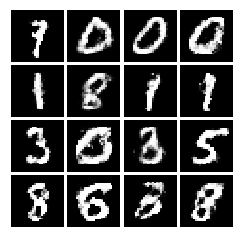

In [292]:
cs, generated_imgs = sess.run([C, generator(Z,C)], 
                              feed_dict={Z: sample_Z(mb_size, Z_dim), C: sample_C(mb_size,C_dim)})
plot(generated_imgs)
print(np.array(cs[:16]).reshape([4,4]))

In [266]:
def cheat_C(m,n,val):
    return np.ones([m,n])*val

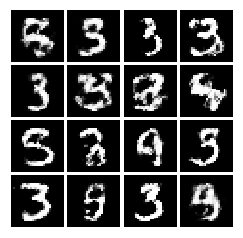

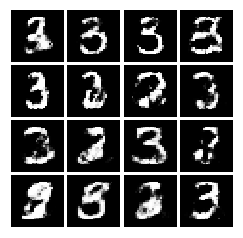

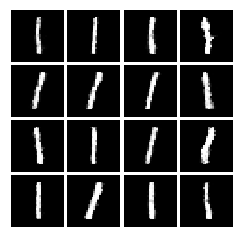

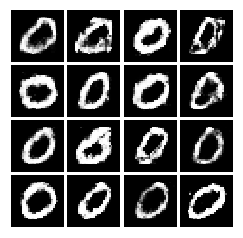

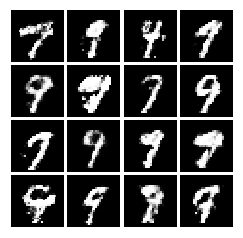

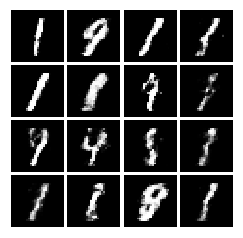

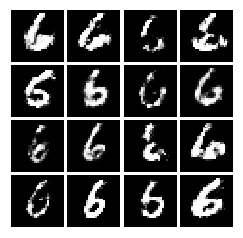

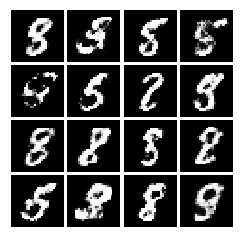

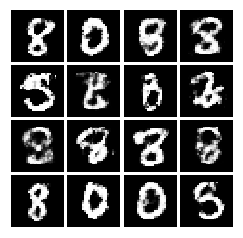

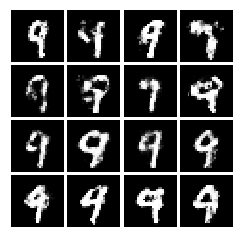

In [296]:
for i in range(10):
    cs, generated_imgs = sess.run([C, generator(Z,C)], 
                                  feed_dict={Z: sample_Z(mb_size, Z_dim), C: cheat_C(mb_size,C_dim, i)})
    plot(generated_imgs)

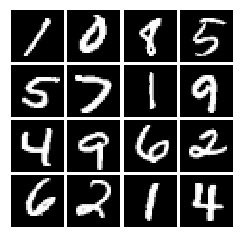

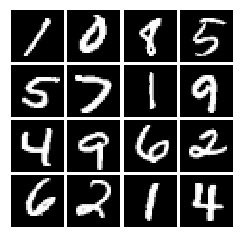

In [97]:
plot(mnist.test.next_batch(16)[0])